In [2]:
using Plots
using LES_ML
using LaTeXStrings
using CUDA
using Distributions

[ Info: Precompiling LES_ML [9bca47e3-315e-42b6-a9a0-21ad79062dce]


In [3]:
N = (256,256)
UPC = 2       


x= collect(LinRange(-pi,pi,N[1]+1))
y = collect(LinRange(-pi,pi,N[2]+1))

fine_mesh = gen_mesh(x,y,UPC = UPC,use_GPU = false)

# number of unknowns per cell

J = (2,2) # compression in each direction
coarse_mesh = gen_coarse_from_fine_mesh(fine_mesh,J)
MP = gen_mesh_pair(fine_mesh,coarse_mesh)
0

FA_filter = gen_FA_filter(J,2) #|> gpu


┌ Info: The CUDA function is being called but CUDA.jl is not functional.
└ Defaulting back to the CPU. (No action is required if you want to run on the CPU).
┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = ConvTranspose((2, 2), 2 => 2, stride=2, bias=false)  # 16 parameters
│   summary(x) = "64×64×2×1 Array{Float64, 4}"
└ @ Flux ~/.julia/packages/Flux/MtsAN/src/layers/stateless.jl:60


Conv((2, 2), 2 => 2, stride=2, bias=false)  # 16 parameters

In [4]:
forcing(x) = sin.(4*x[2])

F = fine_mesh.eval_function(forcing)
F = cat(F,zeros(size(F)),dims = fine_mesh.dims + 1)

F

128×128×2×1 Array{Float64, 4}:
[:, :, 1, 1] =
 0.0980171  0.290285  0.471397  0.634393  …  -0.471397  -0.290285  -0.0980171
 0.0980171  0.290285  0.471397  0.634393     -0.471397  -0.290285  -0.0980171
 0.0980171  0.290285  0.471397  0.634393     -0.471397  -0.290285  -0.0980171
 0.0980171  0.290285  0.471397  0.634393     -0.471397  -0.290285  -0.0980171
 0.0980171  0.290285  0.471397  0.634393     -0.471397  -0.290285  -0.0980171
 0.0980171  0.290285  0.471397  0.634393  …  -0.471397  -0.290285  -0.0980171
 0.0980171  0.290285  0.471397  0.634393     -0.471397  -0.290285  -0.0980171
 0.0980171  0.290285  0.471397  0.634393     -0.471397  -0.290285  -0.0980171
 0.0980171  0.290285  0.471397  0.634393     -0.471397  -0.290285  -0.0980171
 0.0980171  0.290285  0.471397  0.634393     -0.471397  -0.290285  -0.0980171
 0.0980171  0.290285  0.471397  0.634393  …  -0.471397  -0.290285  -0.0980171
 0.0980171  0.290285  0.471397  0.634393     -0.471397  -0.290285  -0.0980171
 0.0980171  0.2902

In [5]:
setup = gen_setup(fine_mesh)
setup_bar = gen_setup(coarse_mesh)

LES_ML.setup_struct(LES_ML.operators_struct(Conv((3, 3), 2 => 1, bias=false), Conv((3, 3), 1 => 2, bias=false), LES_ML.var"#C#86"{Float64, Int64}(0.0981747704246807, Core.Box(Conv((3, 3), 2 => 4, bias=false)), Core.Box(Conv((3, 3), 2 => 4, bias=false)), 2, Core.Box(Conv((3, 3), 4 => 2, bias=false))), Conv((3, 3), 2 => 2, bias=false), Conv((3, 3), 2 => 1, bias=false)), LES_ML.var"#pressure_poisson#40"{LES_ML.var"#pressure_poisson#32#41", Array{Float64, 4}}(LES_ML.var"#pressure_poisson#32#41"(Core.Box(2)), Core.Box([0.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]), [1.0 0.999196986919884 … 3.9871651344789143 0.999196986919884; 0.999196986919884 1.998393973839768 … 4.986362121398798 1.998393973839768; … ; 3.9871651344789143 4.986362121398798 … 7.974330268957829 4.986362121398798; 0.999196986919884 1.998393973839768 … 4.986362121398798 1.998393973839768;;;;]), LES_ML.grid_swapper(LES_ML.mesh_struct(2, (64, 64), [-3.0925052683774528 -3.0925052683774528 … -3.0

In [12]:
max_k = 10
energy_norm = 1
number_of_simulations = 1
Re =1000



setup = gen_setup(fine_mesh)
setup_bar = gen_setup(coarse_mesh)
KF_rhs = gen_rhs(setup,F;Re = Re,damping = 0.1)
coarse_KF_rhs = gen_rhs(setup_bar,FA_filter(F);Re = Re,damping = 0.1)

V = gen_random_field(fine_mesh.N,max_k,norm = energy_norm,samples = (fine_mesh.UPC,number_of_simulations))


    
MV = setup.O.M(padding(V,(1,1),circular = true))



p = setup.PS(MV)

Gp = setup.O.G(padding(p,(1,1),circular =true))

V0 = V-Gp

setup.O.M(V0)[:,:,1,1]

KF_rhs(V0,fine_mesh,0)


128×128×2×1 Array{Float64, 4}:
[:, :, 1, 1] =
 -0.650667    0.60165     1.86503   …  -3.09219   -2.56814    -1.74121
 -1.32169     0.0748971   1.54445      -3.68395   -3.26803    -2.47181
 -1.99888    -0.500175    1.13113      -4.17315   -3.89804    -3.16911
 -2.6112     -1.06507     0.661932     -4.50837   -4.39238    -3.75991
 -3.07474    -1.53905     0.204287     -4.6591    -4.69439    -4.16863
 -3.30253    -1.82804    -0.149984  …  -4.61956   -4.76335    -4.32633
 -3.22032    -1.84291    -0.303469     -4.40483   -4.57827    -4.18148
 -2.7855     -1.52402    -0.18037      -4.04152   -4.13938    -3.7111
 -2.00406    -0.863858    0.246328     -3.55772   -3.46819    -2.93003
 -0.939077    0.0801305   0.938006     -2.97674   -2.60685    -1.89522
  0.293394    1.18908     1.7912    …  -2.31707   -1.61642    -0.702228
  1.54261     2.30376     2.65779      -1.59752   -0.572849    0.526904
  2.65184     3.25846     3.37983      -0.843826   0.44023     1.6632
  ⋮                            

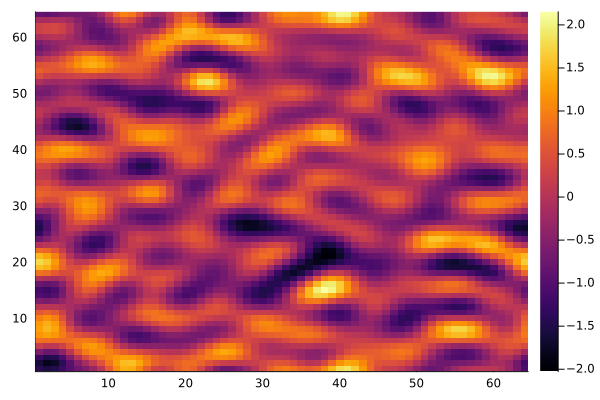

In [13]:
heatmap(Array(FA_filter(V0))[:,:,2,1])

In [14]:
dt = 0.01
save_every = 100
t_start = 0
t_end = 50
pre_allocate = true

t_data,sim_data = simulate(V0,fine_mesh,dt,t_start,t_end,KF_rhs,save_every = save_every,pre_allocate = pre_allocate) 
0

0.0%┣                                         ┫ 0/5.0k [00:01<-2:-1:-36, -1s/it]
0.0%┣                                         ┫ 1/5.0k [00:02<Inf:Inf, InfGs/it]
0.0%┣                                           ┫ 2/5.0k [00:03<03:43:18, 3s/it]
0.1%┣                                              ┫ 5/5.0k [00:03<57:09, 1it/s]
0.2%┣                                              ┫ 9/5.0k [00:03<29:16, 3it/s]
0.2%┣                                             ┫ 12/5.0k [00:03<21:39, 4it/s]
0.3%┣▏                                            ┫ 15/5.0k [00:03<17:19, 5it/s]
0.4%┣▏                                            ┫ 18/5.0k [00:03<14:29, 6it/s]
0.4%┣▏                                            ┫ 21/5.0k [00:03<12:32, 7it/s]
0.5%┣▏                                            ┫ 24/5.0k [00:03<11:04, 7it/s]
0.5%┣▎                                            ┫ 27/5.0k [00:03<09:57, 8it/s]
0.6%┣▎                                            ┫ 30/5.0k [00:03<09:04, 9it/s]
0.7%┣▎                      

6.9%┣███                                        ┫ 344/5.0k [00:09<02:03, 38it/s]
6.9%┣███                                        ┫ 347/5.0k [00:09<02:02, 38it/s]
7.0%┣███                                        ┫ 351/5.0k [00:09<02:02, 38it/s]
7.1%┣███                                        ┫ 355/5.0k [00:09<02:01, 38it/s]
7.2%┣███                                        ┫ 358/5.0k [00:09<02:01, 39it/s]
7.2%┣███                                        ┫ 361/5.0k [00:09<02:00, 39it/s]
7.3%┣███▏                                       ┫ 364/5.0k [00:09<02:00, 39it/s]
7.4%┣███▏                                       ┫ 368/5.0k [00:09<01:59, 39it/s]
7.4%┣███▏                                       ┫ 371/5.0k [00:09<01:59, 39it/s]
7.5%┣███▏                                       ┫ 374/5.0k [00:10<01:58, 39it/s]
7.6%┣███▎                                       ┫ 378/5.0k [00:10<01:58, 39it/s]
7.6%┣███▎                                       ┫ 381/5.0k [00:10<01:57, 39it/s]
7.7%┣███▎                   

14.5%┣██████                                    ┫ 723/5.0k [00:15<01:31, 47it/s]
14.5%┣██████                                    ┫ 727/5.0k [00:15<01:30, 47it/s]
14.6%┣██████▏                                   ┫ 731/5.0k [00:15<01:30, 47it/s]
14.7%┣██████▏                                   ┫ 734/5.0k [00:15<01:30, 47it/s]
14.8%┣██████▏                                   ┫ 738/5.0k [00:16<01:30, 47it/s]
14.8%┣██████▎                                   ┫ 741/5.0k [00:16<01:30, 48it/s]
14.9%┣██████▎                                   ┫ 745/5.0k [00:16<01:29, 48it/s]
15.0%┣██████▎                                   ┫ 748/5.0k [00:16<01:29, 48it/s]
15.0%┣██████▎                                   ┫ 752/5.0k [00:16<01:29, 48it/s]
15.1%┣██████▍                                   ┫ 755/5.0k [00:16<01:29, 48it/s]
15.2%┣██████▍                                   ┫ 758/5.0k [00:16<01:29, 48it/s]
15.2%┣██████▍                                   ┫ 762/5.0k [00:16<01:29, 48it/s]
15.3%┣██████▍               

21.9%┣█████████                                ┫ 1.1k/5.0k [00:21<01:16, 51it/s]
22.0%┣█████████                                ┫ 1.1k/5.0k [00:21<01:16, 51it/s]
22.0%┣█████████                                ┫ 1.1k/5.0k [00:22<01:16, 51it/s]
22.1%┣█████████                                ┫ 1.1k/5.0k [00:22<01:16, 51it/s]
22.2%┣█████████                                ┫ 1.1k/5.0k [00:22<01:16, 51it/s]
22.3%┣█████████▏                               ┫ 1.1k/5.0k [00:22<01:16, 51it/s]
22.3%┣█████████▏                               ┫ 1.1k/5.0k [00:22<01:16, 51it/s]
22.4%┣█████████▏                               ┫ 1.1k/5.0k [00:22<01:16, 51it/s]
22.5%┣█████████▏                               ┫ 1.1k/5.0k [00:22<01:15, 51it/s]
22.6%┣█████████▎                               ┫ 1.1k/5.0k [00:22<01:15, 51it/s]
22.6%┣█████████▎                               ┫ 1.1k/5.0k [00:22<01:15, 51it/s]
22.7%┣█████████▎                               ┫ 1.1k/5.0k [00:22<01:15, 51it/s]
22.8%┣█████████▍            

29.4%┣████████████                             ┫ 1.5k/5.0k [00:28<01:06, 53it/s]
29.4%┣████████████                             ┫ 1.5k/5.0k [00:28<01:06, 53it/s]
29.5%┣████████████                             ┫ 1.5k/5.0k [00:28<01:06, 53it/s]
29.6%┣████████████▏                            ┫ 1.5k/5.0k [00:28<01:06, 53it/s]
29.7%┣████████████▏                            ┫ 1.5k/5.0k [00:28<01:06, 53it/s]
29.8%┣████████████▏                            ┫ 1.5k/5.0k [00:28<01:06, 53it/s]
29.8%┣████████████▎                            ┫ 1.5k/5.0k [00:28<01:06, 53it/s]
29.9%┣████████████▎                            ┫ 1.5k/5.0k [00:28<01:06, 53it/s]
30.0%┣████████████▎                            ┫ 1.5k/5.0k [00:28<01:05, 53it/s]
30.1%┣████████████▎                            ┫ 1.5k/5.0k [00:28<01:05, 53it/s]
30.1%┣████████████▍                            ┫ 1.5k/5.0k [00:28<01:05, 54it/s]
30.2%┣████████████▍                            ┫ 1.5k/5.0k [00:28<01:05, 54it/s]
30.3%┣████████████▍         

37.1%┣███████████████▏                         ┫ 1.9k/5.0k [00:34<00:57, 55it/s]
37.1%┣███████████████▎                         ┫ 1.9k/5.0k [00:34<00:57, 55it/s]
37.2%┣███████████████▎                         ┫ 1.9k/5.0k [00:34<00:57, 55it/s]
37.3%┣███████████████▎                         ┫ 1.9k/5.0k [00:34<00:57, 55it/s]
37.4%┣███████████████▎                         ┫ 1.9k/5.0k [00:34<00:57, 55it/s]
37.4%┣███████████████▍                         ┫ 1.9k/5.0k [00:34<00:57, 55it/s]
37.5%┣███████████████▍                         ┫ 1.9k/5.0k [00:34<00:57, 55it/s]
37.6%┣███████████████▍                         ┫ 1.9k/5.0k [00:34<00:57, 55it/s]
37.6%┣███████████████▍                         ┫ 1.9k/5.0k [00:34<00:57, 55it/s]
37.7%┣███████████████▌                         ┫ 1.9k/5.0k [00:34<00:57, 55it/s]
37.8%┣███████████████▌                         ┫ 1.9k/5.0k [00:34<00:57, 55it/s]
37.9%┣███████████████▌                         ┫ 1.9k/5.0k [00:34<00:57, 55it/s]
37.9%┣███████████████▌      

44.5%┣██████████████████▎                      ┫ 2.2k/5.0k [00:40<00:50, 56it/s]
44.6%┣██████████████████▎                      ┫ 2.2k/5.0k [00:40<00:50, 56it/s]
44.7%┣██████████████████▎                      ┫ 2.2k/5.0k [00:40<00:50, 56it/s]
44.7%┣██████████████████▍                      ┫ 2.2k/5.0k [00:40<00:50, 56it/s]
44.8%┣██████████████████▍                      ┫ 2.2k/5.0k [00:40<00:49, 56it/s]
44.9%┣██████████████████▍                      ┫ 2.2k/5.0k [00:40<00:49, 56it/s]
45.0%┣██████████████████▍                      ┫ 2.2k/5.0k [00:40<00:49, 56it/s]
45.0%┣██████████████████▌                      ┫ 2.3k/5.0k [00:40<00:49, 56it/s]
45.1%┣██████████████████▌                      ┫ 2.3k/5.0k [00:40<00:49, 56it/s]
45.2%┣██████████████████▌                      ┫ 2.3k/5.0k [00:40<00:49, 56it/s]
45.2%┣██████████████████▌                      ┫ 2.3k/5.0k [00:41<00:49, 56it/s]
45.3%┣██████████████████▋                      ┫ 2.3k/5.0k [00:41<00:49, 56it/s]
45.4%┣██████████████████▋   

51.9%┣█████████████████████▎                   ┫ 2.6k/5.0k [00:46<00:43, 56it/s]
51.9%┣█████████████████████▎                   ┫ 2.6k/5.0k [00:46<00:43, 56it/s]
52.0%┣█████████████████████▎                   ┫ 2.6k/5.0k [00:46<00:43, 56it/s]
52.1%┣█████████████████████▍                   ┫ 2.6k/5.0k [00:46<00:42, 56it/s]
52.2%┣█████████████████████▍                   ┫ 2.6k/5.0k [00:46<00:42, 56it/s]
52.2%┣█████████████████████▍                   ┫ 2.6k/5.0k [00:46<00:42, 56it/s]
52.3%┣█████████████████████▍                   ┫ 2.6k/5.0k [00:46<00:42, 56it/s]
52.4%┣█████████████████████▌                   ┫ 2.6k/5.0k [00:46<00:42, 56it/s]
52.5%┣█████████████████████▌                   ┫ 2.6k/5.0k [00:46<00:42, 56it/s]
52.5%┣█████████████████████▌                   ┫ 2.6k/5.0k [00:47<00:42, 56it/s]
52.6%┣█████████████████████▋                   ┫ 2.6k/5.0k [00:47<00:42, 56it/s]
52.7%┣█████████████████████▋                   ┫ 2.6k/5.0k [00:47<00:42, 56it/s]
52.7%┣█████████████████████▋

59.2%┣████████████████████████▎                ┫ 3.0k/5.0k [00:52<00:36, 57it/s]
59.3%┣████████████████████████▎                ┫ 3.0k/5.0k [00:52<00:36, 57it/s]
59.4%┣████████████████████████▍                ┫ 3.0k/5.0k [00:52<00:36, 57it/s]
59.5%┣████████████████████████▍                ┫ 3.0k/5.0k [00:52<00:36, 57it/s]
59.5%┣████████████████████████▍                ┫ 3.0k/5.0k [00:52<00:36, 57it/s]
59.6%┣████████████████████████▍                ┫ 3.0k/5.0k [00:52<00:36, 57it/s]
59.7%┣████████████████████████▌                ┫ 3.0k/5.0k [00:52<00:35, 57it/s]
59.7%┣████████████████████████▌                ┫ 3.0k/5.0k [00:52<00:35, 57it/s]
59.8%┣████████████████████████▌                ┫ 3.0k/5.0k [00:53<00:35, 57it/s]
59.9%┣████████████████████████▋                ┫ 3.0k/5.0k [00:53<00:35, 57it/s]
60.0%┣████████████████████████▋                ┫ 3.0k/5.0k [00:53<00:35, 57it/s]
60.0%┣████████████████████████▋                ┫ 3.0k/5.0k [00:53<00:35, 57it/s]
60.1%┣██████████████████████

66.7%┣███████████████████████████▎             ┫ 3.3k/5.0k [00:58<00:29, 57it/s]
66.7%┣███████████████████████████▍             ┫ 3.3k/5.0k [00:58<00:29, 57it/s]
66.8%┣███████████████████████████▍             ┫ 3.3k/5.0k [00:58<00:29, 57it/s]
66.9%┣███████████████████████████▍             ┫ 3.3k/5.0k [00:58<00:29, 57it/s]
67.0%┣███████████████████████████▌             ┫ 3.3k/5.0k [00:58<00:29, 57it/s]
67.0%┣███████████████████████████▌             ┫ 3.4k/5.0k [00:58<00:29, 57it/s]
67.1%┣███████████████████████████▌             ┫ 3.4k/5.0k [00:59<00:29, 57it/s]
67.2%┣███████████████████████████▌             ┫ 3.4k/5.0k [00:59<00:29, 57it/s]
67.3%┣███████████████████████████▋             ┫ 3.4k/5.0k [00:59<00:29, 57it/s]
67.3%┣███████████████████████████▋             ┫ 3.4k/5.0k [00:59<00:28, 57it/s]
67.4%┣███████████████████████████▋             ┫ 3.4k/5.0k [00:59<00:28, 57it/s]
67.5%┣███████████████████████████▊             ┫ 3.4k/5.0k [00:59<00:28, 57it/s]
67.6%┣██████████████████████

74.0%┣██████████████████████████████▍          ┫ 3.7k/5.0k [01:04<00:23, 58it/s]
74.1%┣██████████████████████████████▍          ┫ 3.7k/5.0k [01:04<00:22, 58it/s]
74.2%┣██████████████████████████████▍          ┫ 3.7k/5.0k [01:04<00:22, 58it/s]
74.3%┣██████████████████████████████▌          ┫ 3.7k/5.0k [01:04<00:22, 58it/s]
74.3%┣██████████████████████████████▌          ┫ 3.7k/5.0k [01:05<00:22, 58it/s]
74.4%┣██████████████████████████████▌          ┫ 3.7k/5.0k [01:05<00:22, 58it/s]
74.5%┣██████████████████████████████▌          ┫ 3.7k/5.0k [01:05<00:22, 58it/s]
74.5%┣██████████████████████████████▋          ┫ 3.7k/5.0k [01:05<00:22, 58it/s]
74.6%┣██████████████████████████████▋          ┫ 3.7k/5.0k [01:05<00:22, 58it/s]
74.7%┣██████████████████████████████▋          ┫ 3.7k/5.0k [01:05<00:22, 58it/s]
74.8%┣██████████████████████████████▋          ┫ 3.7k/5.0k [01:05<00:22, 58it/s]
74.9%┣██████████████████████████████▊          ┫ 3.7k/5.0k [01:05<00:22, 58it/s]
74.9%┣██████████████████████

81.4%┣█████████████████████████████████▍       ┫ 4.1k/5.0k [01:10<00:16, 58it/s]
81.5%┣█████████████████████████████████▍       ┫ 4.1k/5.0k [01:10<00:16, 58it/s]
81.6%┣█████████████████████████████████▌       ┫ 4.1k/5.0k [01:10<00:16, 58it/s]
81.7%┣█████████████████████████████████▌       ┫ 4.1k/5.0k [01:11<00:16, 58it/s]
81.7%┣█████████████████████████████████▌       ┫ 4.1k/5.0k [01:11<00:16, 58it/s]
81.8%┣█████████████████████████████████▌       ┫ 4.1k/5.0k [01:11<00:16, 58it/s]
81.9%┣█████████████████████████████████▋       ┫ 4.1k/5.0k [01:11<00:16, 58it/s]
82.0%┣█████████████████████████████████▋       ┫ 4.1k/5.0k [01:11<00:16, 58it/s]
82.0%┣█████████████████████████████████▋       ┫ 4.1k/5.0k [01:11<00:16, 58it/s]
82.1%┣█████████████████████████████████▋       ┫ 4.1k/5.0k [01:11<00:15, 58it/s]
82.2%┣█████████████████████████████████▊       ┫ 4.1k/5.0k [01:11<00:15, 58it/s]
82.2%┣█████████████████████████████████▊       ┫ 4.1k/5.0k [01:11<00:15, 58it/s]
82.3%┣██████████████████████

88.7%┣████████████████████████████████████▍    ┫ 4.4k/5.0k [01:16<00:10, 58it/s]
88.8%┣████████████████████████████████████▍    ┫ 4.4k/5.0k [01:16<00:10, 58it/s]
88.8%┣████████████████████████████████████▍    ┫ 4.4k/5.0k [01:17<00:10, 58it/s]
88.9%┣████████████████████████████████████▌    ┫ 4.4k/5.0k [01:17<00:10, 58it/s]
89.0%┣████████████████████████████████████▌    ┫ 4.5k/5.0k [01:17<00:09, 58it/s]
89.1%┣████████████████████████████████████▌    ┫ 4.5k/5.0k [01:17<00:09, 58it/s]
89.1%┣████████████████████████████████████▌    ┫ 4.5k/5.0k [01:17<00:09, 58it/s]
89.2%┣████████████████████████████████████▋    ┫ 4.5k/5.0k [01:17<00:09, 58it/s]
89.3%┣████████████████████████████████████▋    ┫ 4.5k/5.0k [01:17<00:09, 58it/s]
89.4%┣████████████████████████████████████▋    ┫ 4.5k/5.0k [01:17<00:09, 58it/s]
89.4%┣████████████████████████████████████▊    ┫ 4.5k/5.0k [01:17<00:09, 58it/s]
89.5%┣████████████████████████████████████▊    ┫ 4.5k/5.0k [01:17<00:09, 58it/s]
89.6%┣██████████████████████

96.1%┣███████████████████████████████████████▍ ┫ 4.8k/5.0k [01:23<00:03, 58it/s]
96.2%┣███████████████████████████████████████▍ ┫ 4.8k/5.0k [01:23<00:03, 58it/s]
96.2%┣███████████████████████████████████████▌ ┫ 4.8k/5.0k [01:23<00:03, 58it/s]
96.3%┣███████████████████████████████████████▌ ┫ 4.8k/5.0k [01:23<00:03, 58it/s]
96.4%┣███████████████████████████████████████▌ ┫ 4.8k/5.0k [01:23<00:03, 58it/s]
96.5%┣███████████████████████████████████████▌ ┫ 4.8k/5.0k [01:23<00:03, 58it/s]
96.5%┣███████████████████████████████████████▋ ┫ 4.8k/5.0k [01:23<00:03, 58it/s]
96.6%┣███████████████████████████████████████▋ ┫ 4.8k/5.0k [01:23<00:03, 58it/s]
96.7%┣███████████████████████████████████████▋ ┫ 4.8k/5.0k [01:23<00:03, 58it/s]
96.8%┣███████████████████████████████████████▊ ┫ 4.8k/5.0k [01:23<00:03, 58it/s]
96.8%┣███████████████████████████████████████▊ ┫ 4.8k/5.0k [01:23<00:03, 58it/s]
96.9%┣███████████████████████████████████████▊ ┫ 4.8k/5.0k [01:23<00:03, 58it/s]
97.0%┣██████████████████████

0

[ Info: Saved animation to /home/toby/Projects/LES_ML.jl/DNS_flow.gif


Plots.AnimatedGif("/home/toby/Projects/LES_ML.jl/DNS_flow.gif")
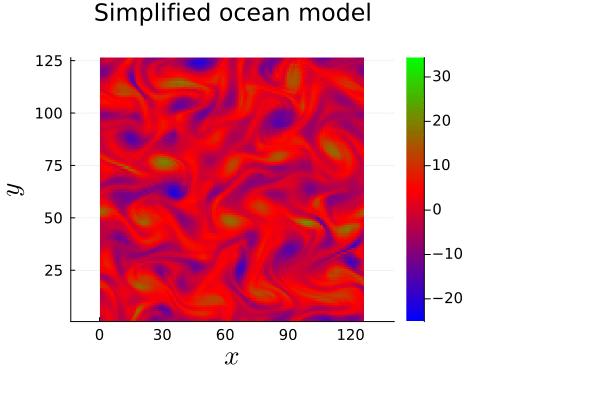

In [15]:
to_plot = Array(setup.O.w(sim_data[:,:,:,1,:]))[:,:,1,:]
#to_plot = setup_bar.O.w(pred_sim[:,:,1:2,:])[:,:,1,:]


ymin = minimum(to_plot)
ymax = maximum(to_plot)


anim = @animate for index in 1:size(to_plot)[3]
    Plots.heatmap(to_plot[:,:,index]',color = :brg,clim = (ymin,ymax),yflip=false,xtickfontsize = 10,ytickfontsize = 10
    ,aspect_ratio = :equal,titlefontsize=16,yguidefontsize=18,xguidefontsize=18,title = "Simplified ocean model",right_margin = 35Plots.mm)
    Plots.xlabel!(L"x")
    Plots.ylabel!(L"y")
    #title!(L"t = " * string(round(example_t[index],digits = 1)))
end

gif(anim, "DNS_flow.gif", fps = 30)

In [16]:
E = Array(fine_mesh.ip(sim_data,sim_data))[1:end]
E_bar = Array(coarse_mesh.ip(MP.FA_filter(sim_data[:,:,:,1,:]),MP.FA_filter(sim_data[:,:,:,1,:])))[1:end]

50-element Vector{Float64}:
  49.009847777831745
  78.51220606000231
 100.4675121950072
 108.21074593304294
 103.7361726227949
  93.62612282342084
  85.0909975413736
  78.83586780188922
  76.82211445833684
  74.46722535222163
  74.6147848430115
  75.50296368608684
  79.67888982516058
   ⋮
  78.90636809389846
  77.84650193748641
  76.24732755620947
  75.70904865346034
  73.38270868752693
  77.61751279297923
  87.03007738979757
  86.96375932297241
  87.56600724812736
  86.34870369121094
  80.1248646149015
  80.59453086622818

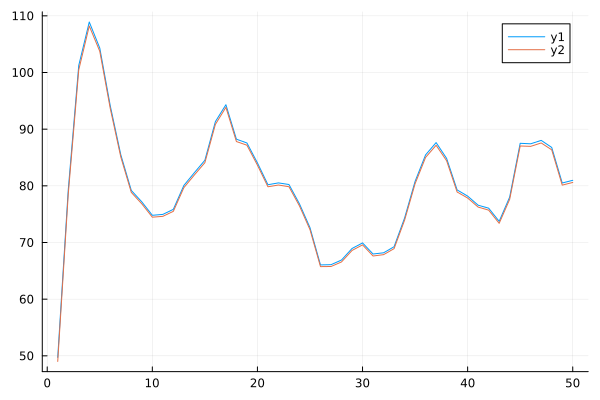

In [17]:
plot(E)
plot!(E_bar)

In [18]:
u = sim_data[:,:,:,1,:]
u_bar = FA_filter(u)

64×64×2×50 Array{Float32, 4}:
[:, :, 1, 1] =
 1.034     1.23756   1.39056   1.30418   …   0.508181      0.692303
 0.993232  1.12101   1.12182   0.987188      0.582502      0.724978
 0.909163  0.950434  0.868591  0.764023      0.594819      0.742882
 0.782248  0.786439  0.716709  0.69693       0.468891      0.677764
 0.63578   0.692231  0.704394  0.716717      0.22316       0.494764
 0.477347  0.613983  0.668448  0.668663  …  -0.000855055   0.277478
 0.350499  0.568126  0.640374  0.643301     -0.0603311     0.123192
 0.2755    0.560034  0.601372  0.514744      0.202562      0.162452
 0.373691  0.499477  0.551323  0.44926       0.456208      0.527414
 0.837737  0.781517  0.561799  0.396714      0.25736       0.588602
 0.710431  1.04377   1.11583   0.69124   …   0.0198204     0.337321
 0.577427  0.895569  1.1568    1.28953      -0.242191      0.19918
 0.459041  0.901979  1.07505   1.3636       -0.685727     -0.123763
 ⋮                                       ⋱                
 0.140868  0.

# Build all the closure models & check on conservative properties

In [19]:
r = 2 # output dimension
BC = "c"
channels = [5,30,30] # inputs: u,v,du/dt,dv/dt,viscosity
strides = [(1,1),(1,1),(1,1)]
kernel_sizes = [(1,1),(1,1),(1,1)]
B = (1,1)
constrain_energy = true
conserve_momentum = true

skew_model = gen_NN(kernel_sizes,channels,strides,r,B;boundary_padding = BC,constrain_energy = constrain_energy, conserve_momentum = conserve_momentum)
0

0

In [20]:
r = 2
BC = "c"
channels = [5,30,30] # inputs: u,v,du/dt,dv/dt,viscosity
strides = [(1,1),(1,1),(1,1)]
kernel_sizes = [(1,1),(1,1),(1,1)]
B = (0,0)
constrain_energy = false
conserve_momentum = false

plain_model = gen_NN(kernel_sizes,channels,strides,r,B;boundary_padding = BC,constrain_energy = constrain_energy, conserve_momentum = conserve_momentum)
0

0

In [21]:
r = 3
BC = "c"
channels = [5,30,30] # inputs: u,v,du/dt,dv/dt,viscosity
strides = [(1,1),(1,1),(1,1)]
kernel_sizes = [(1,1),(1,1),(1,1)]
B = (0,0)
constrain_energy = false
conserve_momentum = false

div_NN = gen_NN(kernel_sizes,channels,strides,r,B;boundary_padding = BC,constrain_energy = constrain_energy, conserve_momentum = conserve_momentum)

function div_model(input;mesh = coarse_mesh,NN = div_NN.eval,SO = SO)

    tau = NN(input)
    return divergence_model(tau,mesh,SO)
end
0

0

In [22]:
r = 1
BC = "c"
channels = [5,30,30] # inputs: u,v,du/dt,dv/dt,viscosity
strides = [(1,1),(1,1),(1,1)]
kernel_sizes = [(1,1),(1,1),(1,1)]
B = (0,0)
constrain_energy = false
conserve_momentum = false

smag_NN = gen_NN(kernel_sizes,channels,strides,r,B;boundary_padding = BC,constrain_energy = constrain_energy, conserve_momentum = conserve_momentum)

SO = gen_smagorinsky_operators(coarse_mesh)
Cs = [0.01]


function smag_model(input;mesh = coarse_mesh,NN = smag_NN.eval,SO = SO)
    dims = mesh.dims
    u_bar = input[[(:) for i in 1:dims]...,1:dims,:]
    Cs = NN(input)
    return smagorinsky_model(u_bar,mesh,Cs,SO)
end


function const_smag_model(input;mesh = coarse_mesh,Cs = Cs,SO = SO)
    dims = mesh.dims
    u_bar = input[[(:) for i in 1:dims]...,1:dims,:]
    return smagorinsky_model(u_bar,mesh,Cs,SO)
end
0

0

In [23]:
FA_filter(F)

64×64×2×1 Array{Float32, 4}:
[:, :, 1, 1] =
 0.194151  0.552895  0.827466  0.976063  …  -0.827466  -0.552895  -0.194151
 0.194151  0.552895  0.827466  0.976063     -0.827466  -0.552895  -0.194151
 0.194151  0.552895  0.827466  0.976063     -0.827466  -0.552895  -0.194151
 0.194151  0.552895  0.827466  0.976063     -0.827466  -0.552895  -0.194151
 0.194151  0.552895  0.827466  0.976063     -0.827466  -0.552895  -0.194151
 0.194151  0.552895  0.827466  0.976063  …  -0.827466  -0.552895  -0.194151
 0.194151  0.552895  0.827466  0.976063     -0.827466  -0.552895  -0.194151
 0.194151  0.552895  0.827466  0.976063     -0.827466  -0.552895  -0.194151
 0.194151  0.552895  0.827466  0.976063     -0.827466  -0.552895  -0.194151
 0.194151  0.552895  0.827466  0.976063     -0.827466  -0.552895  -0.194151
 0.194151  0.552895  0.827466  0.976063  …  -0.827466  -0.552895  -0.194151
 0.194151  0.552895  0.827466  0.976063     -0.827466  -0.552895  -0.194151
 0.194151  0.552895  0.827466  0.976063     

In [24]:
using LES_ML

In [25]:

#Re = 1000



     

const_smag_rhs(u_bar,mesh,t;setup= setup_bar,rhs = coarse_KF_rhs,Re = Re,model = const_smag_model) = neural_rhs(u_bar,mesh,t;setup= setup,rhs = rhs,Re = Re,model = model)
smag_rhs(u_bar,mesh,t;setup= setup_bar,rhs = coarse_KF_rhs,Re = Re,model = smag_model) = neural_rhs(u_bar,mesh,t;setup= setup,rhs = rhs,Re = Re,model = model)
div_rhs(u_bar,mesh,t;setup= setup_bar,rhs = coarse_KF_rhs,Re = Re,model = div_model) = neural_rhs(u_bar,mesh,t;setup= setup,rhs = rhs,Re = Re,model = model)
plain_rhs(u_bar,mesh,t;setup= setup_bar,rhs = coarse_KF_rhs,Re = Re,model = plain_model.eval) = neural_rhs(u_bar,mesh,t;setup= setup,rhs = rhs,Re = Re,model = model)
skew_rhs(u_bar,mesh,t;setup= setup_bar,rhs = coarse_KF_rhs,Re = Re,model = skew_model.eval,B = skew_model.B) = neural_rhs(u_bar,mesh,t;setup= setup,rhs = rhs,Re = Re,model = model,B=B)

skew_rhs (generic function with 1 method)

┌ Warning: Slow fallback implementation invoked for conv!  You probably don't want this; check your datatypes.
│   yT = Float64
│   T1 = Float32
│   T2 = Float64
└ @ NNlib ~/.julia/packages/NNlib/CkJqS/src/conv.jl:192


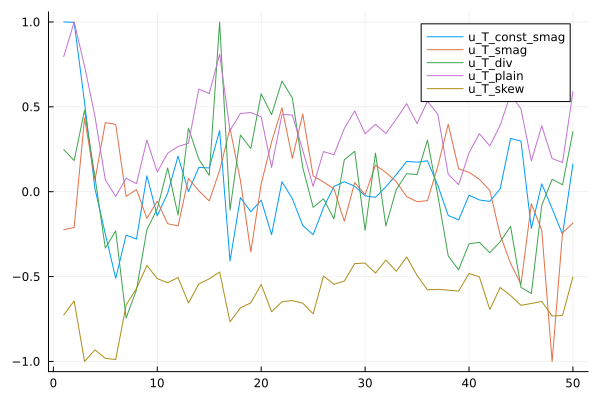

In [26]:
u_T_const_smag = coarse_mesh.ip(const_smag_rhs(u_bar,coarse_mesh,0),u_bar)
u_T_smag = coarse_mesh.ip(smag_rhs(u_bar,coarse_mesh,0),u_bar)
u_T_div = coarse_mesh.ip(div_rhs(u_bar,coarse_mesh,0),u_bar)
u_T_plain = coarse_mesh.ip(plain_rhs(u_bar,coarse_mesh,0),u_bar)
u_T_skew = coarse_mesh.ip(skew_rhs(u_bar,coarse_mesh,0),u_bar)

u_T_const_smag = plot(u_T_const_smag[1:end] ./ maximum(abs.(u_T_const_smag[1:end])),label = "u_T_const_smag")
u_T_smag = plot!(u_T_smag[1:end] ./ maximum(abs.(u_T_smag[1:end])),label = "u_T_smag")
u_T_div = plot!(u_T_div[1:end] ./ maximum(abs.(u_T_div[1:end])),label = "u_T_div")
u_T_plain = plot!(u_T_plain[1:end] ./ maximum(abs.(u_T_plain[1:end])),label = "u_T_plain")
u_T_skew = plot!(u_T_skew[1:end] ./ maximum(abs.(u_T_skew[1:end])),label = "u_T_skew")



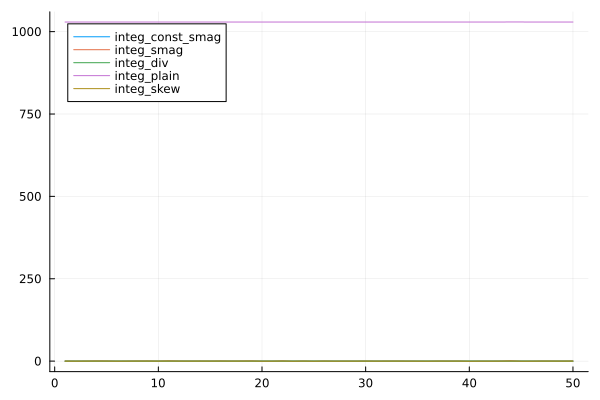

In [27]:
integ_const_smag = coarse_mesh.integ(const_smag_rhs(u_bar,coarse_mesh,0))
integ_smag = coarse_mesh.integ(smag_rhs(u_bar,coarse_mesh,0))
integ_div = coarse_mesh.integ(div_rhs(u_bar,coarse_mesh,0))
integ_plain = coarse_mesh.integ(plain_rhs(u_bar,coarse_mesh,0))
integ_skew = coarse_mesh.integ(skew_rhs(u_bar,coarse_mesh,0))
                    
integ_const_smag = plot(integ_const_smag[1,1,1,:],label = "integ_const_smag")
integ_smag = plot!(integ_smag[1,1,1,:],label = "integ_smag")
integ_div = plot!(integ_div[1,1,1,:],label = "integ_div")
integ_plain = plot!(integ_plain[1,1,1,:],label = "integ_plain")
integ_skew = plot!(integ_skew[1,1,1,:],label = "integ_skew")

In [28]:
save_NN_model(skew_model,"models/skew_model")
save_NN_model(plain_model,"models/plain_model")
save_NN_model(div_NN,"models/div_NN")
save_NN_model(smag_NN,"models/smag_NN")


skew_model = load_NN_model("models/skew_model")
plain_model = load_NN_model("models/plain_model")
div_NN = load_NN_model("models/div_NN")
smag_NN = load_NN_model("models/smag_NN")

0


Model saved at directory [models/skew_model]

Model saved at directory [models/plain_model]

Model saved at directory [models/div_NN]

Model saved at directory [models/smag_NN]

Model loaded from directory [models/skew_model]

Model loaded from directory [models/plain_model]

Model loaded from directory [models/div_NN]

Model loaded from directory [models/smag_NN]


0

In [29]:
c = (FA_filter(KF_rhs(u,fine_mesh,0)) - coarse_KF_rhs(u_bar,coarse_mesh,0))

64×64×2×50 Array{Float64, 4}:
[:, :, 1, 1] =
  0.0912802    0.110751   -0.364237   …   0.0826055  -0.248581     0.199478
 -0.00626653   0.0599473   0.0688229      0.074877   -0.42972     -0.0953641
  0.132484    -0.0665428  -0.0177057      0.166873   -0.346053    -0.279507
  0.112454    -0.0313428  -0.0951193      0.100829    0.00431737  -0.203706
 -0.0672335   -0.174901   -0.0959293      0.100996   -0.0239248   -0.14474
  0.152394     0.0986288   0.0323845  …   0.148503    0.0904155    0.0766504
  0.106952    -0.150822   -0.0262446     -0.0254036  -0.0561198    0.0801712
  0.288428     0.24333    -0.302655       0.085944   -0.548184     0.166234
 -0.109673     0.857073    0.104375       0.175484   -0.0441491   -0.956445
 -0.53907     -1.62174     0.596617      -0.0311457   0.158382     0.365132
  0.40562      0.665666   -1.23935    …   0.144832   -0.00329771  -0.0248593
 -0.247707     0.198395    0.300563       0.104012    0.161114    -0.0591876
  0.204336    -0.468183    0.801872    

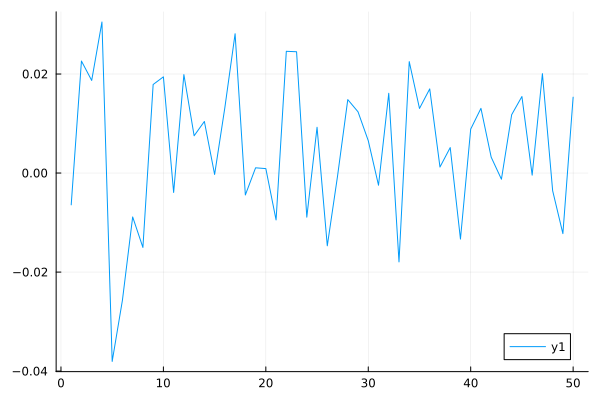

In [30]:
closure_energy = coarse_mesh.ip(c,u_bar)
closure_energy = coarse_mesh.ip(c,u_bar)
plot(closure_energy[1:end])